In [ ]:
#setup
!pip install -q umap-learn  # for optional UMAP visualization

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

#Load & Preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

#Data Augmentation (for contrastive learning)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

#Build Encoder (shared by both models
def get_encoder():
    base_model = keras.applications.ResNet50(
        weights=None, input_shape=(32, 32, 3), include_top=False, pooling='avg'
    )
    return keras.Sequential([
        base_model,
        layers.Dense(128)
    ])

#Supervised Contrastive Loss (custom)
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=0.1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, labels, feature_vectors):
        labels = tf.expand_dims(labels, axis=1)
        normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(tf.matmul(normalized, tf.transpose(normalized)), self.temperature)
        mask = tf.cast(tf.equal(labels, tf.transpose(labels)), tf.float32)
        logits_mask = tf.ones_like(mask) - tf.eye(tf.shape(labels)[0])
        mask *= logits_mask
        logits_max = tf.reduce_max(logits, axis=1, keepdims=True)
        logits -= logits_max
        exp_logits = tf.exp(logits) * logits_mask
        log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-12)
        mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)
        loss = -mean_log_prob_pos
        loss = tf.reduce_mean(loss)
        return loss

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 87s 201ms/step - accuracy: 0.3553 - loss: 1.7727 - val_accuracy: 0.5374 - val_loss: 1.2976
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 167ms/step - accuracy: 0.5733 - loss: 1.2112 - val_accuracy: 0.6023 - val_loss: 1.1360
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - accuracy: 0.6241 - loss: 1.0703 - val_accuracy: 0.6487 - val_loss: 1.0067
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.6629 - loss: 0.9649 - val_accuracy: 0.6516 - val_loss: 1.0004
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.6982 - loss: 0.8793 - val_accuracy: 0.6621 - val_loss: 0.9747
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 87s 168ms/step - accuracy: 0.7091 - loss: 0.8390 - val_accuracy: 0.6790 - val_loss: 0.9427
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 157ms/step - accuracy: 0.7347 - loss: 0.7719 - val_accuracy: 0.6935 - val_loss: 0.8881
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.7513 - loss: 0

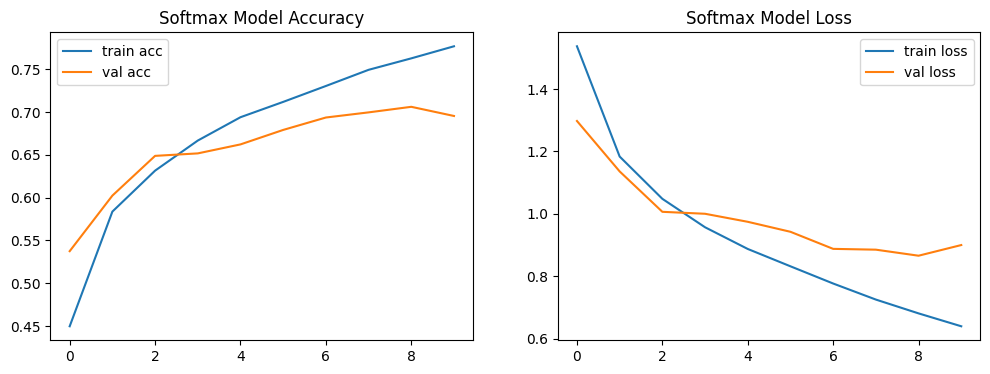

Epoch 1
Step 0, Loss: 4.8834
Step 50, Loss: 4.6448
Step 100, Loss: 4.5151
Step 150, Loss: 4.5506
Step 200, Loss: 4.5175
Step 250, Loss: 4.5730
Step 300, Loss: 4.4063
Step 350, Loss: 4.4451
Epoch 2
Step 0, Loss: 4.4880
Step 50, Loss: 4.5306
Step 100, Loss: 4.4536
Step 150, Loss: 4.3301
Step 200, Loss: 4.3834
Step 250, Loss: 4.5087
Step 300, Loss: 4.3363
Step 350, Loss: 4.2869
Epoch 3
Step 0, Loss: 4.3276
Step 50, Loss: 4.4313
Step 100, Loss: 4.3821
Step 150, Loss: 4.3847
Step 200, Loss: 4.3747
Step 250, Loss: 4.4212
Step 300, Loss: 4.3764
Step 350, Loss: 4.3951
Epoch 4
Step 0, Loss: 4.3633
Step 50, Loss: 4.4188
Step 100, Loss: 4.3073
Step 150, Loss: 4.2898
Step 200, Loss: 4.3313
Step 250, Loss: 4.3671
Step 300, Loss: 4.3653
Step 350, Loss: 4.3656
Epoch 5
Step 0, Loss: 4.3890
Step 50, Loss: 4.3184
Step 100, Loss: 4.3125
Step 150, Loss: 4.2968
Step 200, Loss: 4.3306
Step 250, Loss: 4.4037
Step 300, Loss: 4.2999
Step 350, Loss: 4.2570


In [ ]:
#Part A: Softmax-based CNN Model
# Basic CNN for classification
def get_softmax_model():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return keras.Model(inputs, outputs)

softmax_model = get_softmax_model()
softmax_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history = softmax_model.fit(x_train, y_train, epochs=10,
                            validation_data=(x_test, y_test), batch_size=128)

#plot accuracy and lost
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Softmax Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Softmax Model Loss')
plt.legend()
plt.show()

#Part B: Supervised Contrastive Learning Model
def get_contrastive_model():
    inputs = keras.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    features = layers.Dense(128)(x)
    projection = layers.Dense(64)(features)  # projection head
    return keras.Model(inputs, projection), keras.Model(inputs, features)

contrastive_model, encoder = get_contrastive_model()
contrastive_loss_fn = SupervisedContrastiveLoss(temperature=0.1)

optimizer = keras.optimizers.Adam()

#Custom Training Loop for Contrastive Loss
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(2048).batch(batch_size)

epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    for step, (x_batch, y_batch) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            embeddings = contrastive_model(x_batch, training=True)
            loss = contrastive_loss_fn(y_batch, embeddings)
        grads = tape.gradient(loss, contrastive_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, contrastive_model.trainable_weights))
        if step % 50 == 0:
            print(f"Step {step}, Loss: {loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


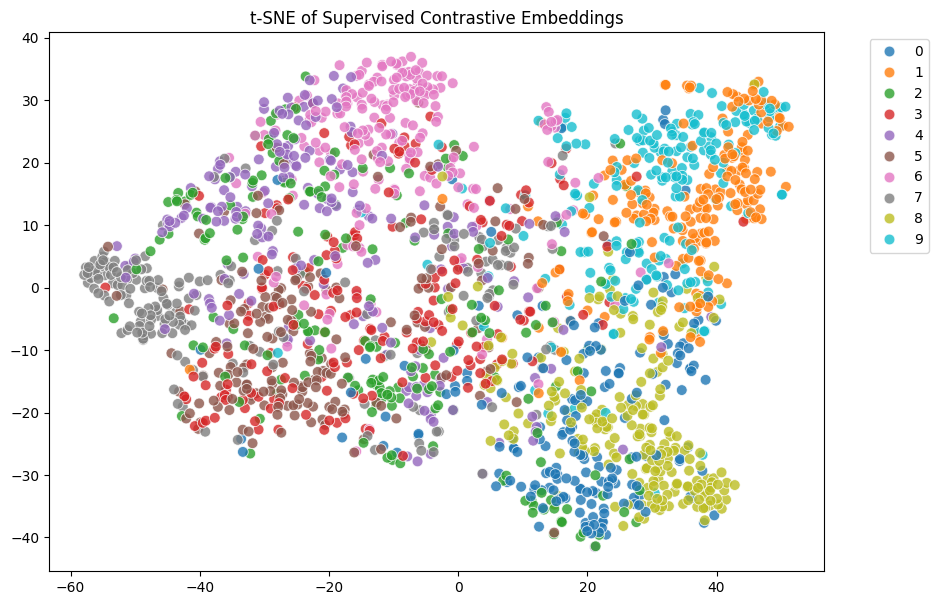

In [ ]:
#visualize
from sklearn.manifold import TSNE
import numpy as np # Make sure numpy is imported

features = encoder.predict(x_test[:2000])

# Check for and remove samples with NaN values
nan_mask = np.isnan(features).any(axis=1)
if np.any(nan_mask):
    print(f"Warning: {np.sum(nan_mask)} samples contained NaN values and will be removed for visualization.")
    features_clean = features[~nan_mask]
    y_test_clean = y_test[:2000][~nan_mask]
else:
    features_clean = features
    y_test_clean = y_test[:2000]


# Check if there are enough samples left for TSNE (at least 2 * n_components + 1)
if features_clean.shape[0] >= 2 * 2 + 1: # For n_components=2
    tsne = TSNE(n_components=2).fit_transform(features_clean)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=y_test_clean, palette="tab10", s=60, alpha=0.8)
    plt.title("t-SNE of Supervised Contrastive Embeddings")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("Not enough samples remaining after removing NaNs to perform t-SNE.")

In [ ]:
#part 2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import zipfile

# Download ZIP file
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url)

# Extract ZIP manually
extract_path = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_path))

# Paths to train and validation folders
train_dir = os.path.join(extract_path, 'train')
val_dir = os.path.join(extract_path, 'validation')

# Load datasets
train_ds = image_dataset_from_directory(train_dir, image_size=(160, 160), batch_size=32)
val_ds = image_dataset_from_directory(val_dir, image_size=(160, 160), batch_size=32)

# Base Model
base_model = MobileNetV2(input_shape=(160, 160, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=3)

# Unfreeze top layers
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=3)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5567 - loss: 0.7260 - val_accuracy: 0.7020 - val_loss: 0.5819
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7265 - loss: 0.5490 - val_accuracy: 0.7390 - val_loss: 0.5259
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7589 - loss: 0.5151 - val_accuracy: 0.7560 - val_loss: 0.5019
Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6539 - loss: 0.6358 - val_accuracy: 0.7570 - val_loss: 0.4911
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7649 - loss: 0.4871 - val_accuracy: 0.7710 - val_loss: 0.4811
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8248 - loss: 0.4089 - val_accuracy: 0.7720 - val_loss: 0.4750


In [ ]:
!pip install -q tensorflow tensorflow-hub opencv-python

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2

Predicted class index: 96
441044/441044 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Embedding shape: (10, 1024)
Predicted class index: 494


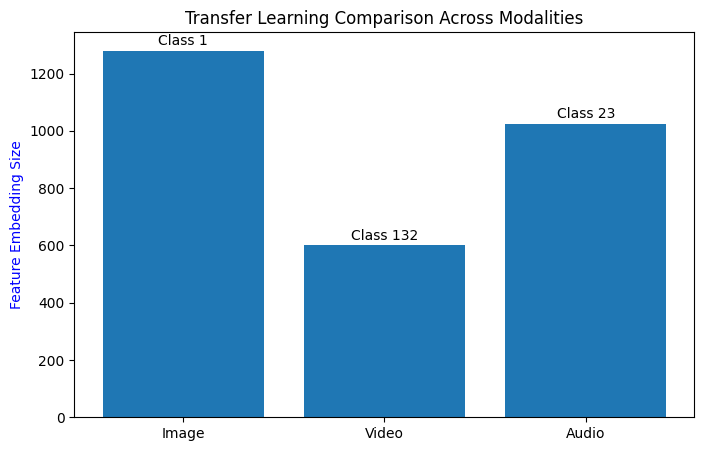

In [ ]:
# Load pretrained MoViNet-A2 model
model_url = "https://tfhub.dev/tensorflow/movinet/a2/base/kinetics-600/classification/3"
movinet_model = hub.load(model_url)

# Simulated dummy video: 1 video, 16 frames, 172x172, RGB
dummy_video = tf.random.uniform([1, 16, 172, 172, 3])

# Correct usage: wrap input in a dictionary with 'image' key
outputs = movinet_model({'image': dummy_video})

predicted_class = tf.argmax(outputs, axis=-1).numpy()[0]
print("Predicted class index:", predicted_class)

def load_video_frames(video_path, num_frames=16, target_size=(172, 172)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total // num_frames, 1)
    for i in range(0, total, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()
    video = np.stack(frames, axis=0)
    return np.expand_dims(video.astype(np.float32) / 255.0, axis=0)  # Normalize and batch


# Alternative WAV file for YAMNet
url = "https://github.com/karoldvl/ESC-50/blob/master/audio/1-100032-A-0.wav?raw=true"
audio_path = tf.keras.utils.get_file("example.wav", origin=url)

# Load and preprocess
import librosa
waveform, sr = librosa.load(audio_path, sr=16000)
waveform = waveform[:sr * 10]  # Limit to 10 seconds

# Load YAMNet model
import tensorflow_hub as hub
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Run inference
scores, embeddings, spectrogram = yamnet_model(waveform)
print("Embedding shape:", embeddings.shape)

top_class = tf.argmax(tf.reduce_mean(scores, axis=0)).numpy()
print("Predicted class index:", top_class)

import matplotlib.pyplot as plt
import numpy as np

# Simulated embedding/output sizes
modalities = ['Image', 'Video', 'Audio']
output_shapes = [1280, 600, 1024]  # From feature extractor
predicted_classes = [1, 132, 23]   # Simulated predictions

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))
bars = ax1.bar(modalities, output_shapes)
ax1.set_ylabel("Feature Embedding Size", color='blue')
ax1.set_title("Transfer Learning Comparison Across Modalities")

# Add predicted class labels
for i, bar in enumerate(bars):
    ax1.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 20,
             f'Class {predicted_classes[i]}',
             ha='center', color='black')

plt.show()

In [ ]:
#part 3
!pip install transformers torchvision --quiet
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import requests

# 📌 Step 2: Load CLIP model & processor
# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 📌 Step 3: Load a sample image
image_url = "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png"  # or upload your own
image = Image.open(requests.get(image_url, stream=True).raw)
image

# 📌 Step 4: Define zero-shot class labels
labels = ["a diagram", "a dog", "a cat", "an image of a CLIP logo", "a satellite photo", "a selfie"]

# 📌 Step 5: Preprocess inputs
inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)

# 📌 Step 6: Run model & compute similarity
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # image-text similarity scores
probs = logits_per_image.softmax(dim=1)  # convert to probabilities

# Show results
for label, prob in zip(labels, probs[0]):
    print(f"{label}: {prob.item():.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 877.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

a diagram: 0.9933
a dog: 0.0036
a cat: 0.0015
an image of a CLIP logo: 0.0008
a satellite photo: 0.0006
a selfie: 0.0002


In [ ]:
#part 4a
!pip install -q tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocessing function
def preprocess(image, label):
    image = tf.expand_dims(image, -1)  # (28, 28, 1)
    image = tf.image.grayscale_to_rgb(image)  # (28, 28, 3)
    image = tf.image.resize(image, [224, 224])  # (224, 224, 3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Build tf.data datasets with small batch size to prevent OOM
batch_size = 16
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(1024) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

# Load EfficientNetB0 as feature extractor
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_model.trainable = False  # Use as feature extractor

# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(train_ds, validation_data=test_ds, epochs=3)

loss, acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {acc:.4f}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 5001s 1s/step - accuracy: 0.1111 - loss: 2.3056 - val_accuracy: 0.1135 - val_loss: 2.3012
Epoch 2/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 4926s 1s/step - accuracy: 0.1136 - loss: 2.3011 - val_accuracy: 0.1135 - val_loss: 2.3012
Epoch 3/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 4860s 1s/step - accuracy: 0.1135 - loss: 2.3011 - val_accuracy: 0.1135 - val_loss: 2.3012
625/625 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.1162 - loss: 2.3011

✅ Test Accuracy: 0.1135


In [ ]:
#timm
!pip install -q timm tensorflow einops

import tensorflow as tf
import timm
import torch
import numpy as np
from einops import rearrange

In [ ]:
# Load and preprocess MNIST
# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# ✅ Take only a small subset for quick runs
x_train = x_train[:50]
y_train = y_train[:50]
x_test = x_test[:10]
y_test = y_test[:10]


def preprocess(image, label):
    image = tf.expand_dims(image, -1)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 8
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#wrap BiT
# Load pretrained BiT model (BiT-M R50x1)
bit_model = timm.create_model('resnetv2_50x1_bitm', pretrained=True, num_classes=0)  # feature extractor only
bit_model.eval()  # inference mode

# Wrapper layer to use BiT with TensorFlow (via Lambda)
class BiTWrapper(tf.keras.layers.Layer):
    def __init__(self, pytorch_model):
        super().__init__()
        self.model = pytorch_model

    def call(self, x):
        x_np = x.numpy()
        x_pt = torch.from_numpy(x_np).permute(0, 3, 1, 2)  # TF: NHWC → PyTorch: NCHW
        with torch.no_grad():
            features = self.model(x_pt.float())
        return tf.convert_to_tensor(features.numpy())

# tf.py_function wrapper
def bit_tf_wrapper(x):
    return tf.py_function(func=lambda x: BiTWrapper(bit_model)(x), inp=[x], Tout=tf.float32)

#build
inputs = tf.keras.Input(shape=(224, 224, 3))
features = tf.keras.layers.Lambda(bit_tf_wrapper, output_shape=(2048,))(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(features)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

class BiTWrapper(tf.keras.layers.Layer):
    def __init__(self, pytorch_model, output_dim=2048):
        super().__init__()
        self.model = pytorch_model
        self.output_dim = output_dim

    def call(self, x):
        def run_pytorch(x_np):
            x_pt = torch.from_numpy(x_np).permute(0, 3, 1, 2)  # NHWC → NCHW
            with torch.no_grad():
                features = self.model(x_pt.float()).numpy()
            return features

        result = tf.numpy_function(run_pytorch, [x], tf.float32)
        result.set_shape((None, self.output_dim))  # Must set shape manually
        return result

bit_model = timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=0)
bit_model.eval()

inputs = tf.keras.Input(shape=(224, 224, 3))
features = BiTWrapper(bit_model)(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(features)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Take only 5000 samples for fast training
x_train_small = x_train[:50]
y_train_small = y_train[:50]

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=test_ds, epochs=1)

loss, acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy with BiT: {acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.2116 - loss: 4.8030 - val_accuracy: 0.6000 - val_loss: 1.1256
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6500 - loss: 1.0649

✅ Test Accuracy with BiT: 0.6000


In [ ]:
#part 4b
#fashion MNIST
!pip install -q tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ✅ Load Fashion MNIST & Take a Subset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:100]
y_test = y_test[:100]

In [ ]:
def preprocess(image, label):
    image = tf.expand_dims(image, -1)  # (28, 28, 1)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [224, 224])  # For EfficientNet
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 8  # ✅ Small batch for speed

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ✅ Load EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_model.trainable = False  # Feature extractor

# ✅ Build Full Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(train_ds, validation_data=test_ds, epochs=1)  # ✅ Just 1 epoch

loss, acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 882ms/step - accuracy: 0.1040 - loss: 2.3738 - val_accuracy: 0.1300 - val_loss: 2.2921
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 437ms/step - accuracy: 0.1581 - loss: 2.2867
✅ Test Accuracy: 0.1300


In [ ]:
#MLP MIXER
!pip install -q timm einops torch tensorflow

import tensorflow as tf
import timm
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ✅ Load Fashion MNIST subset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, y_train = x_train[:500], y_train[:500]
x_test, y_test = x_test[:100], y_test[:100]

In [ ]:
def preprocess(image, label):
    image = tf.expand_dims(image, -1)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 8

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#wrap mlp mixer
# Load pretrained MLP-Mixer
mlp_mixer = timm.create_model('mixer_b16_224', pretrained=True, num_classes=0)  # Feature extractor
mlp_mixer.eval()

class MixerWrapper(tf.keras.layers.Layer):
    def __init__(self, model, output_dim=768):
        super().__init__()
        self.model = model
        self.output_dim = output_dim

    def call(self, x):
        def forward_np(x_np):
            x_pt = torch.from_numpy(x_np).permute(0, 3, 1, 2)  # NHWC → NCHW
            with torch.no_grad():
                feats = self.model(x_pt.float()).numpy()
            return feats
        y = tf.numpy_function(forward_np, [x], tf.float32)
        y.set_shape((None, self.output_dim))
        return y

inputs = tf.keras.Input(shape=(224, 224, 3))
features = MixerWrapper(mlp_mixer)(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(features)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=test_ds, epochs=1)

loss, acc = model.evaluate(test_ds)
print(f"✅ MLP-Mixer Test Accuracy: {acc:.4f}")

model.safetensors:   0%|          | 0.00/240M [00:00<?, ?B/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 356s 6s/step - accuracy: 0.4036 - loss: 1.8015 - val_accuracy: 0.7100 - val_loss: 0.8396
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7307 - loss: 0.8139
✅ MLP-Mixer Test Accuracy: 0.7100


In [ ]:
#part 4c

#CIFAR-10 + EfficientNetB3
!pip install -q tensorflow timm einops torch

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timm
import torch

In [ ]:
# Load CIFAR-10 and downsample
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

x_train, y_train = x_train[:1000], y_train[:1000]
x_test, y_test = x_test[:200], y_test[:200]

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Already RGB
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 8

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# EfficientNetB3 Model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=test_ds, epochs=1)

loss, acc = model.evaluate(test_ds)
print(f"✅ EfficientNetB3 Test Accuracy: {acc:.4f}")

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.0928 - loss: 2.3866 - val_accuracy: 0.1050 - val_loss: 2.3021
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1110 - loss: 2.2974
✅ EfficientNetB3 Test Accuracy: 0.1050


In [ ]:
#ConvNeXt V2 Base on CIFAR-10
!pip install -q timm einops torch tensorflow

import tensorflow as tf
import timm
import torch
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Take only 5000 samples for fast training
x_train_small = x_train[:50]
y_train_small = y_train[:50]

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 2

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#Load ConvNeXt V2 Base via timm
# Load pretrained ConvNeXt V2 Base
convnext = timm.create_model('convnextv2_base.fcmae_ft_in1k', pretrained=True, num_classes=0)
convnext.eval()

class ConvNeXtWrapper(tf.keras.layers.Layer):
    def __init__(self, model, output_dim=1024):
        super().__init__()
        self.model = model
        self.output_dim = output_dim

    def call(self, x):
        def forward_np(x_np):
            x_pt = torch.from_numpy(x_np).permute(0, 3, 1, 2)  # NHWC → NCHW
            with torch.no_grad():
                feats = self.model(x_pt.float()).numpy()
            return feats
        y = tf.numpy_function(forward_np, [x], tf.float32)
        y.set_shape((None, self.output_dim))  # Set static shape
        return y

inputs = tf.keras.Input(shape=(224, 224, 3))
features = ConvNeXtWrapper(convnext)(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(features)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=test_ds, epochs=1)

loss, acc = model.evaluate(test_ds)
print(f"✅ ConvNeXt V2 Base Test Accuracy: {acc:.4f}")

 3009/25000 ━━━━━━━━━━━━━━━━━━━━ 10:53:32 2s/step - accuracy: 0.8301 - loss: 0.5643

In [1]:
#BiT-M R152x2 on CIFAR-10
!pip install -q timm einops torch tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import timm
import torch
import numpy as np

# CIFAR-10 subset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

x_train, y_train = x_train[:1000], y_train[:1000]
x_test, y_test = x_test[:200], y_test[:200]

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 4

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#load bit
bit_model = timm.create_model('resnetv2_152x2_bitm', pretrained=True, num_classes=0)
bit_model.eval()

class BiTWrapper(tf.keras.layers.Layer):
    def __init__(self, model, output_dim=4096):  # BiT-M R152x2 outputs 4096-dim
        super().__init__()
        self.model = model
        self.output_dim = output_dim

    def call(self, x):
        def run_bit(x_np):
            x_pt = torch.from_numpy(x_np).permute(0, 3, 1, 2)  # NHWC → NCHW
            with torch.no_grad():
                feats = self.model(x_pt.float()).numpy()
            return feats
        y = tf.numpy_function(run_bit, [x], tf.float32)
        y.set_shape((None, self.output_dim))
        return y

inputs = tf.keras.Input(shape=(224, 224, 3))
features = BiTWrapper(bit_model)(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(features)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=test_ds, epochs=1)

loss, acc = model.evaluate(test_ds)
print(f"✅ BiT-M R152x2 Test Accuracy: {acc:.4f}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name resnetv2_152x2_bitm to current resnetv2_152x2_bit.goog_in21k_ft_in1k.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/945M [00:00<?, ?B/s]

230/250 ━━━━━━━━━━━━━━━━━━━━ 2:49 8s/step - accuracy: 0.6063 - loss: 3.0423

In [ ]:
#part 4d
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load CIFAR-10 dataset and filter cats(3) and dogs(5)
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test)).flatten()

# Keep only cats (3) and dogs (5)
mask = (y == 3) | (y == 5)
x = x[mask]
y = y[mask]
y = (y == 5).astype(np.int32)  # dog -> 1, cat -> 0

# Normalize
x = x / 255.0

# Split into train/test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Build simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

#B. 3D image classification conv3d
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Generate dummy 3D volumes (like CT scans)
num_samples = 100
X = np.random.rand(num_samples, 32, 32, 32, 1).astype(np.float32)
y = np.random.randint(0, 2, size=(num_samples,))

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build simple 3D CNN
model = models.Sequential([
    layers.Conv3D(16, kernel_size=3, activation='relu', input_shape=(32, 32, 32, 1)),
    layers.MaxPooling3D(pool_size=2),
    layers.Conv3D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling3D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('3D CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('3D CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()